In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
#from torch.nn.utils import clip_grad_norm_
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [2]:
experiment       = 'synth1'
abduction        = False
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [3]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
n_varsll = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
n_varshl = len(Ghl.nodes())


omega    = mut.load_omega_map(experiment)

In [4]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

In [5]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [6]:
def check_for_invalid_values(matrix):
    if torch.isnan(matrix).any() or torch.isinf(matrix).any():
        #print("Matrix contains NaN or Inf values!")
        return True
    return False

def handle_nans(matrix, replacement_value=0.0):
    # Replace NaNs with a given value (default is 0)
    if torch.isnan(matrix).any():
        print("Warning: NaN values found! Replacing with zero.")
        matrix = torch.nan_to_num(matrix, nan=replacement_value)
    return matrix

In [7]:
theta_hatL   = {'mu_U': mu_U_ll_hat, 'Sigma_U': Sigma_U_ll_hat, 'radius': epsilon}
theta_hatH   = {'mu_U': mu_U_hl_hat, 'Sigma_U': Sigma_U_hl_hat, 'radius': delta}

seed = 42

In [8]:
def plot_overall_progress(objectives_list, robust=False):
    """
    Plot objective values over epochs from a simple list.
    
    Args:
        objectives_list: List of objective values per epoch
        robust: Boolean flag (not used in this simplified version)
    """
    plt.figure(figsize=(10, 6))
    
    # Create x-axis values (epoch numbers)
    epochs = range(1, len(objectives_list) + 1)
    
    # Plot the objectives
    sns.lineplot(
        x=epochs,
        y=objectives_list,
        color='blue',
        label='Objective'
    )
    
    plt.title('Optimization Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Objective Value')
    plt.grid(True, alpha=0.3)
    
    # Add markers to better see individual points
    plt.scatter(epochs, objectives_list, color='blue', alpha=0.5, s=30)
    
    # Scientific notation for y-axis if values are very small/large
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    plt.show()

### Theta Maximization (works)

In [9]:
def grad_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L):

    term1     = torch.zeros_like(mu_L)
    for n, iota in enumerate(Ill):
        L_i   = torch.from_numpy(LLmodels[iota].F).float() 
        V_i   = T @ L_i  
        H_i   = torch.from_numpy(HLmodels[omega[iota]].F).float() 

        term1 = term1 + V_i.T @ V_i @ mu_L.float() - V_i.T @ H_i @ mu_H.float()
    
    term2     = -2 * lambda_L * (mu_L - hat_mu_L)
    grad_mu_L = (2 / (n+1)) * term1 - term2
    
    return grad_mu_L

def grad_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H):

    term1     = torch.zeros_like(mu_H)
    for n, iota in enumerate(Ill):
        L_i   = torch.from_numpy(LLmodels[iota].F).float()  
        V_i   = T @ L_i  
        H_i   = torch.from_numpy(HLmodels[omega[iota]].F).float()  

        term1 = term1 + H_i.T @ H_i @ mu_H.float() - (V_i.T @ H_i).T @ mu_L.float()
    
    term2     = -2 * lambda_H * (mu_H - hat_mu_H)
    grad_mu_H = (2 / (n+1)) * term1 - term2

    return grad_mu_H


def grad_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L):

    term1            = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i          = torch.from_numpy(LLmodels[iota].F)
        V_i          = T @ L_i.float()

        term1        = term1 + V_i.T @ V_i

    Sigma_L_sqrt     = oput.sqrtm_svd(Sigma_L)  
    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L) 

    term2            = -2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)
    grad_Sigma_L     = (2 / (n+1)) * term1 - term2
    
    return grad_Sigma_L

def grad_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H):

    term1            = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i          = torch.from_numpy(HLmodels[omega[iota]].F).float()
        
        term1        = term1 + H_i.T @ H_i

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    term2            = -2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)
    grad_Sigma_H     = (2 / (n+1)) * term1 - term2

    return grad_Sigma_H

def prox_grad_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param_L):

    Sigma_L               = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i               = torch.from_numpy(LLmodels[iota].F).float()  
        V_i               = oput.regmat(T @ L_i)  
        H_i               = torch.from_numpy(HLmodels[omega[iota]].F).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = V_i @ Sigma_L_half @ V_i.T
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V)) 
        
        prox_Sigma_L_half = oput.prox_operator(sqrtm_V_Sigma_V, lambda_param_L) @ oput.prox_operator(sqrtm_V_Sigma_V, lambda_param_L).T
        
        ll_term           = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half) @ oput.regmat(torch.linalg.pinv(V_i).T)

        Sigma_H           = Sigma_H.float()  
        H_Sigma_H         = H_i @ Sigma_H @ H_i.T

        hl_term           = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro') 

        Sigma_L           = Sigma_L + (ll_term * hl_term)

    Sigma_L_final         = (2 / (n+1)) * Sigma_L 
    Sigma_L_final         = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final

def prox_grad_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H):

    Sigma_H               = torch.zeros_like(Sigma_H_half, dtype=torch.float32)
    for n, iota in enumerate(Ill):
        L_i               = torch.from_numpy(LLmodels[iota].F).float()
        V_i               = oput.regmat(T @ L_i)
        H_i               = torch.from_numpy(HLmodels[omega[iota]].F).float()

        Sigma_H_half      = Sigma_H_half.float()
        H_Sigma_H         = H_i @ Sigma_H_half @ H_i.T
        sqrtm_H_Sigma_H   = oput.sqrtm_svd(oput.regmat(H_Sigma_H)) 
        #H_Sigma_H         = oput.regmat(H_i @ Sigma_H_half @ H_i.T)
  
        prox_Sigma_H_half = oput.prox_operator(sqrtm_H_Sigma_H, lambda_param_H) @ oput.prox_operator(sqrtm_H_Sigma_H, lambda_param_H).T
        hl_term_iota      = oput.regmat(torch.inverse(H_i)) @ prox_Sigma_H_half @ oput.regmat(torch.inverse(H_i).T)
        
        Sigma_L           = Sigma_L.float()
        V_Sigma_V         = V_i @ Sigma_L @ V_i.T
        ll_term_iota      = torch.norm(oput.sqrtm_svd(oput.regmat(V_Sigma_V)), p='fro')

        Sigma_H           = Sigma_H + (ll_term_iota * hl_term_iota)
    
    Sigma_H_final         = (2 / (n+1)) * Sigma_H
    Sigma_H_final         = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

In [10]:
def run_theta_optimization_max(theta_hatL, theta_hatH, initial_theta,
                                epsilon, delta, lambda_L, lambda_H, lambda_param_L, lambda_param_H,  
                                eta_min, eta_max, max_iter, num_steps_min, num_steps_max,
                                tol, seed, robust, plot_steps, plot_epochs, display_results):
                
    # Start timing
    start_time = time.time()

    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)

    hat_mu_L, hat_Sigma_L = torch.from_numpy(theta_hatL['mu_U']).float(), torch.from_numpy(theta_hatL['Sigma_U']).float()
    hat_mu_H, hat_Sigma_H = torch.from_numpy(theta_hatH['mu_U']).float(), torch.from_numpy(theta_hatH['Sigma_U']).float()

    l = hat_mu_L.shape[0]
    h = hat_mu_H.shape[0]

    if initial_theta == 'gelbrich':
        # Gelbrich initialization
        ll_moments    = mut.sample_moments_U(mu_hat = theta_hatL['mu_U'], Sigma_hat = theta_hatL['Sigma_U'], bound = epsilon, num_envs = 1)
        mu_L, Sigma_L = ll_moments[0]
        mu_L, Sigma_L = torch.from_numpy(mu_L).float(), torch.from_numpy(Sigma_L).float()

        hl_moments    = mut.sample_moments_U(mu_hat = theta_hatH['mu_U'], Sigma_hat = theta_hatH['Sigma_U'], bound = delta, num_envs = 1)
        mu_H, Sigma_H = hl_moments[0]
        mu_H, Sigma_H = torch.from_numpy(mu_H).float(), torch.from_numpy(Sigma_H).float()

    elif initial_theta == 'empirical':
        mu_L, Sigma_L = hat_mu_L, hat_Sigma_L
        mu_H, Sigma_H = hat_mu_H, hat_Sigma_H

    T = torch.randn(h, l, requires_grad=True)
    # # Initialize momentum terms
    # v_mu_L = torch.zeros_like(mu_L)
    # v_mu_H = torch.zeros_like(mu_H)
    # beta = 0.9  # momentum coefficient


    previous_objective = float('inf')  
    theta_objs = []
    for epoch in tqdm(range(max_iter)): 
        # grad_mu_L_val = grad_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L)
        # grad_mu_H_val = grad_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H)
        
        # # print(f"Gradient norms - mu_L: {torch.norm(grad_mu_L_val).item()}, mu_H: {torch.norm(grad_mu_H_val).item()}")
        mu_L         = mu_L + eta_max * grad_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L)

        mu_H         = mu_H + eta_max * grad_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H)

        Sigma_L_half = Sigma_L + eta_max * grad_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L)
        Sigma_L      = prox_grad_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param_L)

        Sigma_H_half = Sigma_H + eta_max * grad_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H)
        Sigma_H      = prox_grad_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H)
        
        # Project onto Gelbrich balls
        mu_L, Sigma_L = oput.project_onto_gelbrich_ball(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        mu_H, Sigma_H = oput.project_onto_gelbrich_ball(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        # Verify constraints
        satisfied_L, dist_L, epsi = oput.verify_gelbrich_constraint(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        satisfied_H, dist_H, delt = oput.verify_gelbrich_constraint(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        if not satisfied_L:
            print(f"Warning: Constraints not satisfied for mu_L and Sigma_L! Distance: {dist_L} and epsilon = {epsilon}")

        if not satisfied_H:
            print(f"Warning: Constraints not satisfied for mu_H and Sigma_H! Distance: {dist_H} and delta = {delta}")
        
        obj = 0
        for iota in Ill:
            L_i = torch.from_numpy(LLmodels[iota].F)
            H_i = torch.from_numpy(HLmodels[omega[iota]].F)

            obj_value_iota = oput.compute_objective_value(T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H, lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H, epsilon, delta)
            obj = obj + obj_value_iota
            
        obj = obj/len(Ill)
        print(f"obj: {obj.item()} at epoch {epoch+1}/{max_iter}")
        theta_objs.append(obj.item())

        # Check convergence
        criterion = abs(previous_objective - obj.item()) 
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {obj.item()}")
            break

        previous_objective = obj.item()


    paramsL = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
    paramsH = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}

    T = T.detach().numpy()
    
    end_time = time.time()
    elapsed_time = end_time - start_time

    if display_results == True:
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T, theta_objs

  2%|▏         | 2/100 [00:00<00:08, 10.93it/s]


obj: 1.8761385679244995 at epoch 1/100
obj: 1.8718338012695312 at epoch 2/100
obj: 1.8718338012695312 at epoch 3/100
Convergence reached at epoch 3 with objective 1.8718338012695312

               OPTIMIZATION RESULTS               

Final Transformation Matrix T:
------------------------------
[[ 0.3367  0.1288  0.2345]
 [ 0.2303 -1.1229 -0.1863]]

Condition Number: 2.7909

Low-Level Parameters:
------------------------------
μ_L = [-0. -0. -0.]
Σ_L = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

High-Level Parameters:
------------------------------
μ_H = [ 0.0038 -0.003 ]
Σ_H = 
[[0.9296 0.    ]
 [0.     0.0262]]

Optimization time: 0.2143 seconds


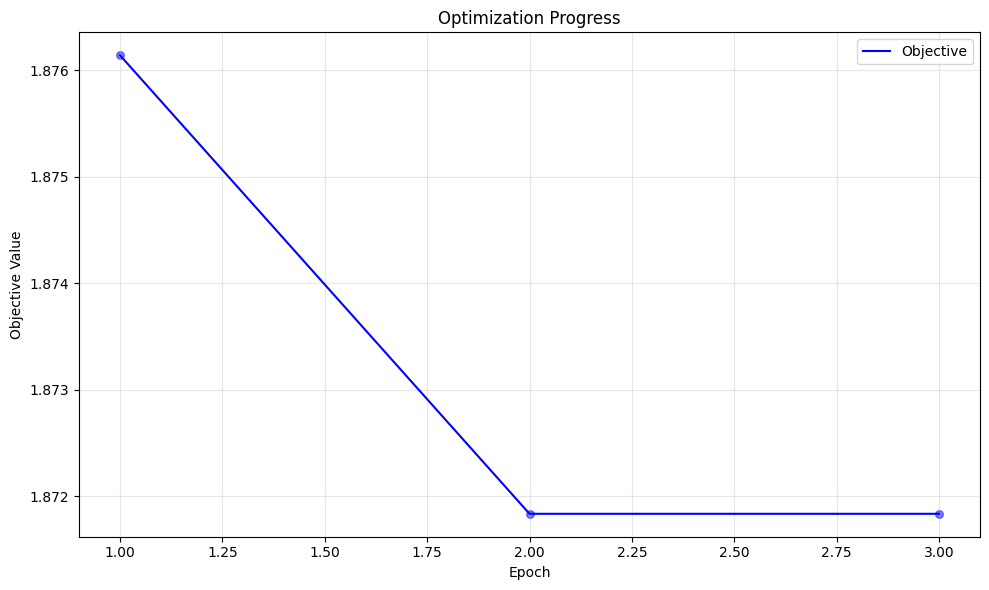

In [11]:
params_max =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': 2,
                    'delta': 2,
                    'lambda_L': .9,
                    'lambda_H': 1,
                    'lambda_param_L': 4, # when high monotonic increase
                    'lambda_param_H': 4, # when high monotonic increase
                    'eta_max': 0.00001,
                    'eta_min': 0.0001,
                    'max_iter': 100,
                    'num_steps_min': 4,
                    'num_steps_max': 3,
                    'tol': 1e-8,
                    'seed': seed,
                    'robust': True,
                    'plot_steps': True,
                    'plot_epochs': True,
                    'display_results': True
                }

params_L_max, params_H_max, T_max, objs = run_theta_optimization_max(**params_max)
plot_overall_progress(objs)